# Implementing deep separation building blocks

Most deep separation networks that have cropped up in
recent years use and re-use many of the same components. While
some papers introduce new types of layers, often there are still
components that can be abstracted out and used across multiple
network architectures. This structure has solidified in recent years, with
at least two open source projects - Asteroid and nussl - recognizing this.

This chapter is meant to acquaint you with the exact implementations of each
of these building blocks, and eventually build them up to a few different,
interesting, network architectures that are seen throughout the source
separation literature.

## Deep mask estimation

Our story starts with one of the more established methods for deep audio
source separation - *learning the mask*. Recall that the goal of many
audio source separation algorithms before deep learning was to construct the optimal
mask that when applied to the STFT (or other invertible time-frequency representation
such as the CQT) of the mixture, produced an estimate of the isolated source - vocals,
accompaniment, speaker one, speaker two, etc. When deep networks first came on the
scene, one obvious thing to do was to create a deep network that would predict
the masks directly.

```{note}
Some early work tried to predict the magnitudes directly, but this generally resulted
in worse performance. Things may be changing though, with some recent work.
```

### Model overview

In the sections below we will be building up a deep mask estimation model. The model
takes a representation of the mixture (the magnitude spectrogram), and converts it
into a mask with the following steps:

1. Convert magnitude spectrogram to log-magnitude spectrogram.
2. Normalize the log-magnitude spectrogram.
3. Process the log-magnitude spectrogram with a stack of recurrent neural networks.
4. Convert the output of the recurrent stack to a mask that can be applied to the mixture.

This is a "simple" model that is for mostly pedagogical purposes, but does work well
for some separation problems. We'll look at more complicated models later on.

We'll start with the last step, so that we understand the output of the network. Then, 
we'll learn how to do the first 3 steps. A model in PyTorch always looks like this:

In [1]:
import torch
from torch import nn
import nussl

nussl.utils.seed(0)
to_numpy = lambda x: x.detach().numpy()
to_tensor = lambda x: torch.from_numpy(x).reshape(-1, 1).float()

class Model(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data):
        return data

In the `__init__` function, you save everything the model needs to do its computation.
This includes initialized building blocks, and any other variables needed. In the 
forward function, you define the actual data flow of the model as it goes from input
to output (in this case a mask).

### Masking

The first building block we'll look at is one of the simplest ones - a mask. As we saw
in previous chapters, one way to perform separation is to element-wise multiply a
mask with a *representation*. This representation is generally the magnitude
spectrogram. We'll start by introducing it in numpy, and then move towards doing
it in PyTorch.

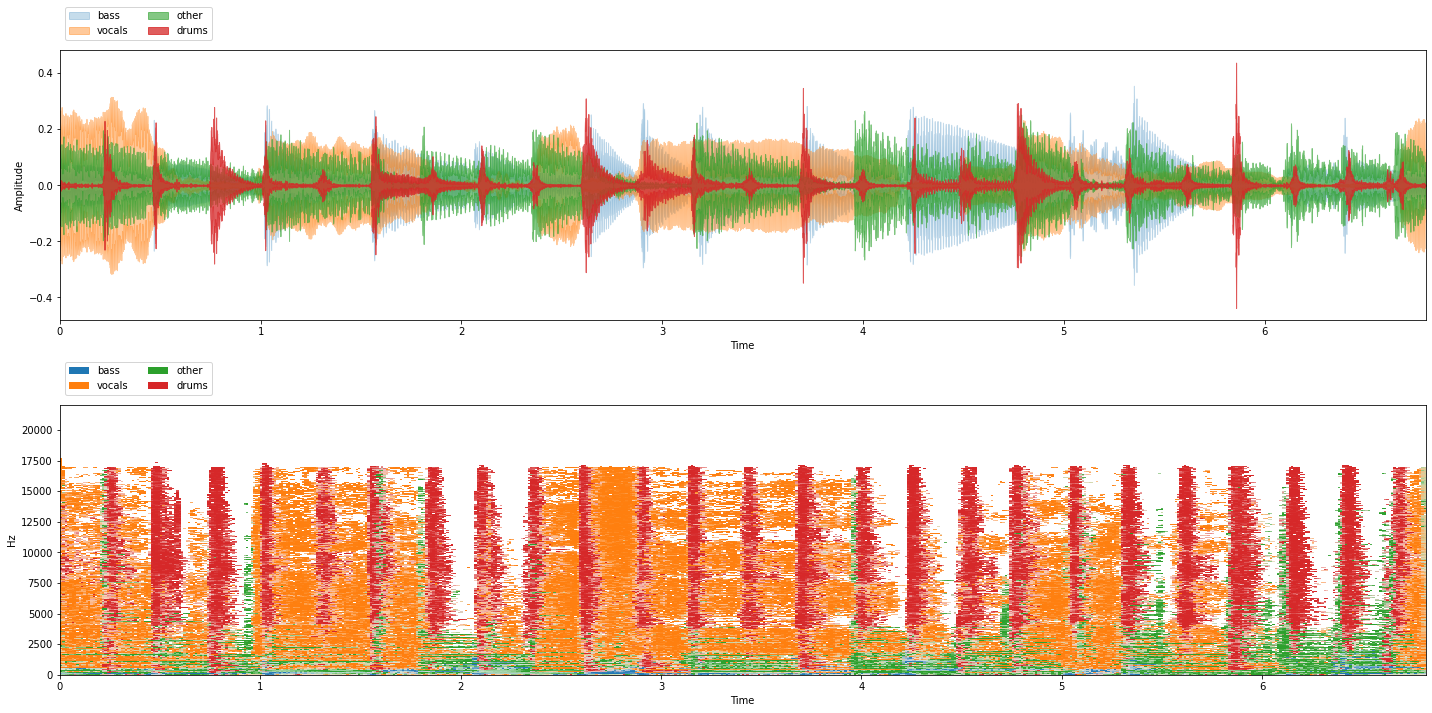


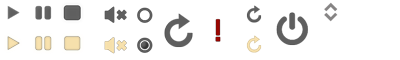
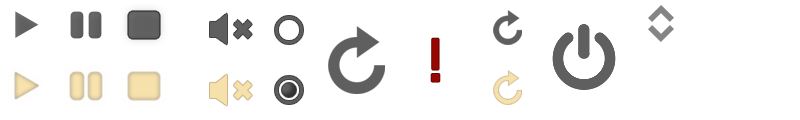
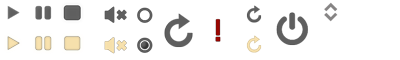

In [2]:
import torch
import nussl
from common import viz
import numpy as np
import matplotlib.pyplot as plt

musdb = nussl.datasets.MUSDB18(download=True)
item = musdb[40]

viz.show_sources(item['sources'])

In the lower plot, we can see a visualization of the mask required for each source to separate 
it from the mixture. Let's do the operation of actually masking in numpy first:

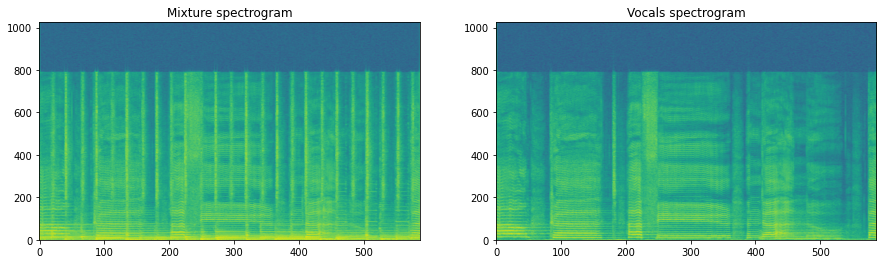

In [3]:
representation = np.abs(item['mix'].stft())
vocals_representation = np.abs(item['sources']['vocals'].stft())

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(representation[..., 0]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(20 * np.log10(vocals_representation[..., 0]), origin='lower', aspect='auto')
ax[1].set_title('Vocals spectrogram')
plt.show()

Now that we've got the representation of both the mixture spectrogram and the vocals
spectrogram, let's build a soft mask for the vocals. This is done via the following
formula, where mask $M(t, f) \in [0, 1]$, $X(t, f)$ is the energy of the mixture spectrogram
at each time-frequency point, and $Y(t, f)$ is the energy of the vocals spectrogram
at each time-frequency point:

$$Y(t, f) = M(t, f) * X(t, f)$$

We can solve for $M$:

$$\frac{Y(t, f)}{\max(X(t, f), Y(t, f)) + \epsilon} = M(t, f) $$

We take the maximum of the source spectrogram and the mixture spectrogram so that $M(t, f)$  stays
between $0$ and $1$. This will become important later when we actually build the network.
Okay, so given all that, the implementation is straightforward in numpy:

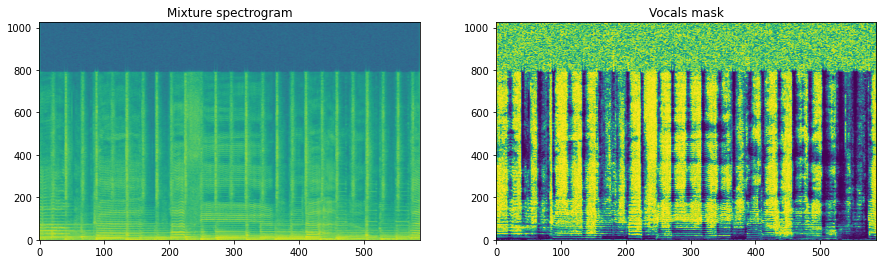

In [4]:
mask = vocals_representation / (np.maximum(vocals_representation, representation) + 1e-8)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(representation[..., 0]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(mask[..., 0], origin='lower', aspect='auto')
ax[1].set_title('Vocals mask')
plt.show()

Now we see the actual mask. To actually apply the mask, just multiply it element-wise with the mixture
spectrogram:

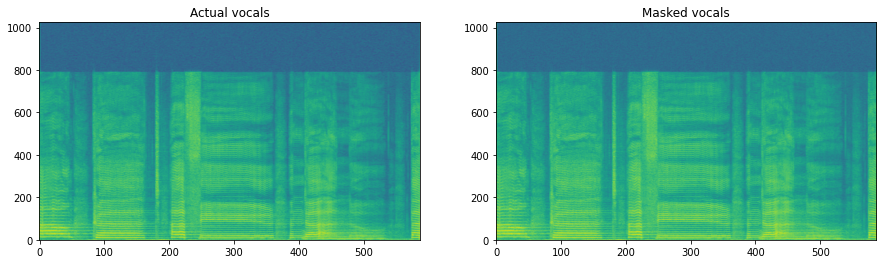

In [5]:
masked = mask * representation
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(vocals_representation[..., 0]), origin='lower', aspect='auto')
ax[0].set_title('Actual vocals')
ax[1].imshow(20 * np.log10(masked[..., 0]), origin='lower', aspect='auto')
ax[1].set_title('Masked vocals')
plt.show()

Let's actually listen to the separation by combining the masked magnitudes with the mixture
phase:

In [6]:
mix_phase = np.angle(item['mix'].stft())
masked_stft = masked * np.exp(1j * mix_phase)
new_signal = nussl.AudioSignal(stft=masked_stft, sample_rate=item['mix'].sample_rate)
new_signal.istft()
new_signal.embed_audio(display=False)

Sounds pretty good! We've established that masking works pretty well for separating sources, 
and that masking is a relatively easy operation. Let's convert things to PyTorch tensors
to see how the numpy code above translates:

In [7]:
mix_tensor = torch.from_numpy(representation)
mask_tensor = torch.rand_like(mix_tensor.unsqueeze(-1))

# shapes
print(mix_tensor.shape, mask_tensor.shape)

# masking operation:
masked_tensor = mix_tensor.unsqueeze(-1) * mask_tensor

print(masked_tensor.shape)

torch.Size([1025, 587, 2]) torch.Size([1025, 587, 2, 1])
torch.Size([1025, 587, 2, 1])


Here, we just constructed a random mask and then element-wise multiplied it. One thing to 
note here are the shapes! The shape of the mix tensor is:

1. Number of frequency bins in FFT
2. Number of time steps
3. Number of audio channels

The mask tensor has one additional dimension:

- Number of sources (here only 1 source).

```{note}
In practice, there will also be a batch dimension, which will be the 0th dimension. 
Also, in general, the time dimension will be the first non-batch dimension (1st), and
frequency will be the 2nd. This is a matter of convention, however.
```

So for example, to separate four sources, we would just need 4 masks that 
are stacked. When multiplied against the mix tensor, it broadcasts, 
resulting in 4 separated sources. Note that we needed to unsqueeze
the mix tensor, adding an extra dummy dimension, so that this multiplication
works.

The point of the rest of the blocks in this section is to create a mask that we can
apply to the time-frequency representation of the mixture. Keep this in mind
as we introduce the rest of the blocks. First, let's introduce different ways
we can process the mixture spectrogram.

### Log-magnitude representation

One component of this model (but not all models) is to compute the log-magnitude 
representation. To see why we do this, compare the histogram of the magnitude-spectrogram
with the log-magnitude spectrogram:

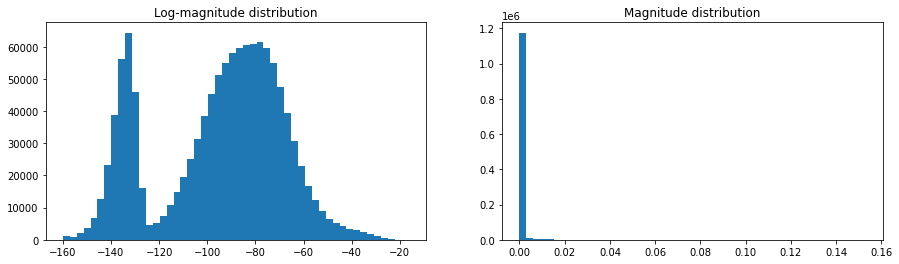

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(20 * np.log10(np.maximum(representation, 1e-8)).flatten(), bins=50)
ax[0].set_title('Log-magnitude distribution')
ax[1].hist(representation.flatten(), bins=50)
ax[1].set_title('Magnitude distribution')
plt.show()

Distributions that look those on the left are generally more much friendly for neural network training. 
Second, log-magnitude representations more closely match the human perception of volume which is 
logarithmic, not linear. A 3dB boost in volume perceptually doubles the volume of a sound. Log-magnitude
representations generally give neural networks a leg up, both in terms of activations as well as a good
representation of the audio that it starts from.

To do this in `nussl`, we simply use the `AmplitudeToDB` layer that is built in:

In [9]:
from nussl.ml.networks.modules import AmplitudeToDB

amplitude_to_db = AmplitudeToDB()
mix_log_amplitude = amplitude_to_db(mix_tensor)
print(mix_tensor.mean(), mix_log_amplitude.mean())

tensor(0.0004, dtype=torch.float64) tensor(-75.9872, dtype=torch.float64)


Now let's put this in our actual model as our first building block. Let's also reshape 
the mix_tensor a bit for future use so that it follows this pattern (which is what
nussl building blocks expect):

1. Dim 0: Batch size
2. Dim 1: Sequence length (# of time steps)
3. Dim 2: # of frequency bins
4. Dim 3: # of audio channels (not to be confused with convolutional channels)

In [10]:
mix_tensor.shape

torch.Size([1025, 587, 2])

In [11]:
print("Shape before (nf, nt, nac): ", mix_tensor.shape)
mix_tensor = mix_tensor.permute(1, 0, 2).unsqueeze(0).float()
print("Shape after (nb, nt, nf, nac):", mix_tensor.shape)

Shape before (nf, nt, nac):  torch.Size([1025, 587, 2])
Shape after (nb, nt, nf, nac): torch.Size([1, 587, 1025, 2])


In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
    
    def forward(self, data):
        data = self.amplitude_to_db(data)
        return data
    
model = Model()
mix_log_amplitude = model(mix_tensor)

Our model now takes a mix spectrogram and computes the log magnitude features.

### Input normalization

Input normalization is a critical feature of most deep separation models. In neural networks,
activation functions work best within a limited range of values. For example, let's look
at a plot of the Sigmoid activation function:

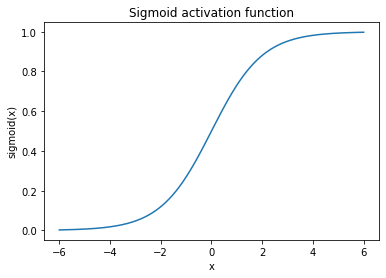

In [13]:
x = torch.linspace(-6, 6, 1000)
y = torch.sigmoid(x)
plt.plot(to_numpy(x), to_numpy(y))
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Sigmoid activation function')
plt.show()

The "good" range for the Sigmoid function is between -6 and 6. What happens as you go further out?

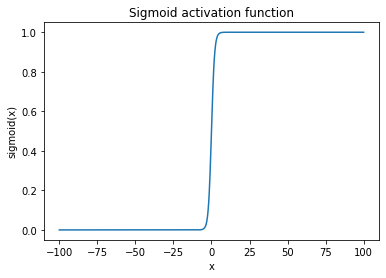

In [14]:
x = torch.linspace(-100, 100, 1000)
y = torch.sigmoid(x)
plt.plot(to_numpy(x), to_numpy(y))
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Sigmoid activation function')
plt.show()

The sigmoid function saturates more and more below $-6$ or above $6$. This means that the activations
coming from this layer will be basically useless if we feed in log-magnitude spectrogram features
which range from $-160$  to $-20$. Not just Sigmoid, but all activation functions such as TanH, ReLU, etc.
have this issue. So in order to give the network the best chance at learning what we want it to learn, 
we use *input normalization*. The same principles can apply to inner layers of the network as well (e.g.
batch normalization, layer normalization, etc). The simplest way to apply input normalization (sometimes
also called whitening), is to use nussl's BatchNorm layer, as follows:

In [15]:
from nussl.ml.networks.modules import BatchNorm

def print_stats(data):
    print(
        f"Shape: {data.shape}\n"
        f"Mean: {data.mean().item()}\n"
        f"Var: {data.var().item()}\n"
    )

input_normalization = BatchNorm(num_features=mix_tensor.shape[2])
mix_log_amplitude = amplitude_to_db(mix_tensor)

print_stats(mix_tensor)
print_stats(mix_log_amplitude)

normalized = input_normalization(mix_log_amplitude)

print_stats(mix_log_amplitude)
print_stats(normalized)


Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 1025, 2])
Mean: -75.98722076416016
Var: 67.525146484375

Shape: torch.Size([1, 587, 1025, 2])
Mean: -75.98722076416016
Var: 67.525146484375

Shape: torch.Size([1, 587, 1025, 2])
Mean: -1.6677076075666264e-07
Var: 0.7717075943946838



The batch norm layer in `nussl` automatically applies batch normalization to each frequency band, which is another
popular trick for training separation networks. Note the mean and variance before and after the normalization. After
the normalization the mean is close 0 and the variance is close to 1, which is much better for most activation functions
to deal with.

Let's stick it in our model:

In [16]:
class Model(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
    
    def forward(self, data):
        data = self.amplitude_to_db(data)
        data = self.input_normalization(data)
        return data

num_features = mix_tensor.shape[2]
model = Model(num_features)
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)

Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 1025, 2])
Mean: -1.6677076075666264e-07
Var: 0.7717075943946838



### Recurrent processing

This is the heart of this model - a stack of recurrent layers that extract features from the normalized
input representation of the mixture. The recurrent layer in nussl takes input with this shape:

1. Batch
2. Time
3. Frequency
4. Audio channels

and produces output with this shape:

1. Batch
2. Time
3. Hidden size

where the hidden size is decided by the end user. The bigger the hidden size, the more parameters the 
network has and thus higher capacity.

```{note}
This block is where all the real magic happens. But it doesn't have to be a stack of recurrent layers!
It can also be a stack of convolutions, dilated convolutions, or whatever else you want.
```

To implement the recurrent stack, we'll use the nussl layer `RecurrentStack`. This layer does the following
steps:

1. Reshapes the input data from `(nb, nt, ...)` to `(nb, nt, -1)`, where `-1` indicates however many points
   are left. If the input is multichannel, then the last dimension will be of size `nf * nac`, where `nac` is the
   number of audio channels.
2. Processes the input via a multi-layer stack of recurrent layers (generally LSTMs, but GRU is also an option).

In [17]:
from nussl.ml.networks.modules import RecurrentStack

nb, nt, nf, nac = mix_tensor.shape
recurrent_stack = RecurrentStack(
    nf * nac, 
    hidden_size=50, 
    num_layers=2, 
    bidirectional=True, 
    dropout=0.3
)

output = recurrent_stack(normalized)
print_stats(mix_tensor)
print_stats(output)

Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 100])
Mean: 1.4655892073278665e-06
Var: 0.1167059913277626



Let's stick this into our model:

In [18]:
class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
    def forward(self, data):
        data = self.amplitude_to_db(data)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        return data

nb, nt, nf, nac = mix_tensor.shape
model = Model(nf, nac, 50, 2, True, 0.3)
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)

Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 100])
Mean: 0.0008972622454166412
Var: 0.11712745577096939



```{note}
The `bidirectional` argument has an impact on which use-cases your model
is appropriate for. If set to True, then your model will not be able to work
in real time, as bidirectionality means that the model looks both forwards and
backwards in time to predict features from a given sequence.  Bidirectionality
also doubles the size of the model, as the implementation is just two identical RNNs,
one of which operates on the sequence in the original order, and the other which
operates on the sequence in the reverse order.
```

```{tip}
What should you set these arguments to? Great question. Literature has landed on a couple
different variants, which we'll say in the form of `num_layers x hidden_size:

- 3x512
- 2x300
- 4x300
- 4x600 (large model)

Generally more layers > bigger hidden size.
```

### Mapping to a mask

We now want to map the output of the recurrent stack to a mask that we can actually
apply to the mixture. Recall from the first section that a mask:

- has the same shape as the representation, save for an extra dimension for the sources.
- is non-negative, and often between 0 and 1.

With that in mind, we currently have the output of the recurrent stack, which has shape
`(batch, time, hidden_size)`. We need to map it to `(batch, time, num_features, num_audio_channels, num_sources)`.
We'll do this by using the Embedding layer from `nussl`.

The Embedding layer performs the following steps:

1. Moves the dimension to be embedded (by default the last) to the end.
2. Uses a linear layer to map to (num_features * num_audio_channels * num_sources).
3. Reshapes the output of the linear layer.
4. Applies a non-linear activation function to the output (e.g. Sigmoid, ReLU, etc).

This time, we'll go straight to the updated model code:

In [19]:
from nussl.ml.networks.modules import Embedding

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        data = self.amplitude_to_db(data)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        data = self.embedding(data)
        return data

nb, nt, nf, nac = mix_tensor.shape
model = Model(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)


Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 1025, 2, 1])
Mean: 0.4999110698699951
Var: 0.0007009883993305266



We've now built up to producing a mask. Let's look at the mask:

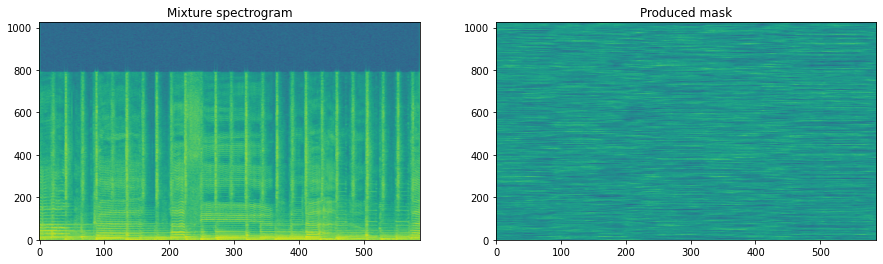

In [20]:
mask = to_numpy(output[0, ..., 0])

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(representation[..., 0]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(mask[..., 0].T, origin='lower', aspect='auto')
ax[1].set_title('Produced mask')
plt.show()

As our model is currently untrained, the produced mask is completely random.

### Applying the mask

The final step in the model is to actually apply the mask to the mixture representation.
Using the steps we talked about before, let's put that in the model code:

In [21]:
from nussl.ml.networks.modules import Embedding

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        
        estimates = mix_magnitude.unsqueeze(-1) * mask
        return estimates

nb, nt, nf, nac = mix_tensor.shape
model = Model(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)


Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 1025, 2, 1])
Mean: 0.00022055231966078281
Var: 1.7174875210912433e-06



Let's take a look at the produced estimate:

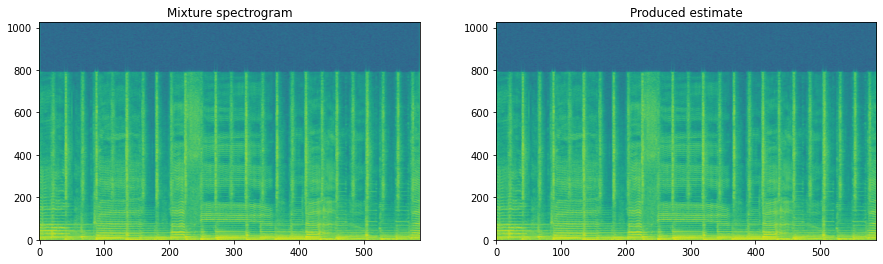

In [22]:
estimate = to_numpy(output[0, ..., 0])

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(representation[..., 0]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(20 * np.log10(estimate[..., 0].T), origin='lower', aspect='auto')
ax[1].set_title('Produced estimate')
plt.show()

```{note}
One reason we use masking inside the network is to make life easier for the network. All it
has to do for every time-frequency point is to decide whether it belongs or doesn't belong, rather
than trying to estimate the magnitude directly, which can be a much tougher problem to try
and solve.
```

## Deep Clustering

Deep clustering is an alternative way to train source separation networks. The idea is to project
every time-frequency point to a D-dimensional unit-normalized embedding, and then use K-means
clustering to extract the actual sources. 

To make our model a deep clustering model, all we have to do is change how the "Embedding"
layer works:

In [23]:
from nussl.ml.networks.modules import Embedding

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, embedding_size, 
                activation=['sigmoid', 'unit_norm']):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   embedding_size, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        
        estimates = mix_magnitude.unsqueeze(-1) * mask
        return estimates

nb, nt, nf, nac = mix_tensor.shape
model = Model(nf, nac, 50, 2, True, 0.3, 20, ['sigmoid', 'unit_norm'])
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)


Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 587, 1025, 2, 20])
Mean: 9.828247129917145e-05
Var: 3.380243072115263e-07



The output of the network are now 20-dimensional time-frequency points. We can visualize
the embedding space using PCA (Principle Component Analysis):

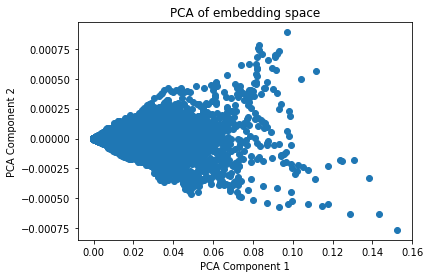

In [24]:
from sklearn.decomposition import PCA

np_output = to_numpy(output.reshape(-1, 20))
pca = PCA(n_components=2)
pca_output = pca.fit_transform(np_output)

plt.scatter(pca_output[:, 0], pca_output[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of embedding space')
plt.show()


Since we haven't trained the network at all, yet, it's just a big blob (one cluster).
With a trained network, you'd see multiple tight clusters.

## Deep audio estimation

In recent years, the trend has gone towards learning to output the waveform directly.
In this part, we'll build up a waveform in/waveform out model by adding components to
our already built mask estimation model.

### Taking the STFT/iSTFT in a forward pass

The first step in creating a waveform in/waveform out model is to move the computation of
the STFT and inverse STFT inside the model function. `nussl` has an STFT module built in
with both directions (transform and inverse) implemented. `nussl`'s implementation is built
to match the Scipy STFT implementation as close as possible. Let's use it:

In [105]:
from nussl.ml.networks.modules import STFT

stft = STFT(2048, hop_length=512)
mix_audio = torch.from_numpy(item['mix'].audio_data).unsqueeze(0).float()
scipy_mag = np.abs(item['mix'].stft())
torch_stft = stft(mix_audio, direction='transform')
print(torch_stft.shape, scipy_mag.shape)

torch.Size([1, 587, 2050, 2]) (1025, 587, 2)


There are a few things to note here:

- The ordering of dimensions is different. In the torch STFT, the time axis
  goes second and the frequency axis third. There's also a batch dimension.
- The torch STFT has twice the features along the frequency dimension. This is
  because the first half are the magnitude features and the second half are
  the phase features.
  
Let's compute the magnitude spectrogram of the torch STFT:

torch.Size([1, 587, 2, 1025, 2])
torch.Size([1, 587, 1025, 2])


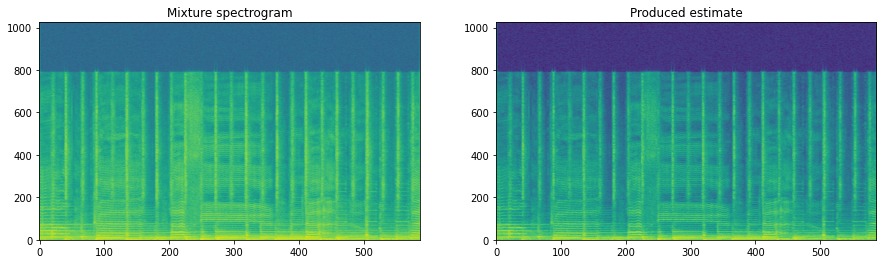

In [106]:
nb, nt, nf, nac = torch_stft.shape
# Stack the real/imag along the second to last axis
torch_stft = torch_stft.reshape(nb, nt, 2, -1, nac)
print(torch_stft.shape)
# Compute the magnitude
torch_mag, torch_phase = torch_stft[:, :, 0, ...], torch_stft[:, :, 1, ...]
print(torch_mag.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(scipy_mag[..., 0]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(20 * np.log10(torch_mag[0, ..., 0].T), origin='lower', aspect='auto')
ax[1].set_title('Produced estimate')
plt.show()

In [114]:
np.abs(torch_mag[0, ...,].permute(1, 0, 2).numpy() - scipy_mag).max()

4.583906270533289e-08

Above, you can see the error between torch STFT and scipy STFT is on the order
of 1e-8. Now, let's modify our model so that it takes the STFT and iSTFT:

In [127]:
from nussl.ml.networks.modules import Embedding

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, embedding_size, 
                 num_filters, hop_length, window_type='sqrt_hann', # New STFT parameters
                 activation=['sigmoid', 'unit_norm']):
        super().__init__()
        
        self.stft = STFT(
            num_filters, 
            hop_length=hop_length, 
            window_type=window_type
        )
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   embedding_size, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        # Take STFT inside model
        mix_stft = self.stft(data, direction='transform')
        nb, nt, nf, nac = mix_stft.shape
        # Stack the mag/phase along the second to last axis
        mix_stft = mix_stft.reshape(nb, nt, 2, -1, nac)
        mix_magnitude = mix_stft[:, :, 0, ...] # save for masking
        mix_phase = mix_stft[:, :, 1, ...] # save for reconstruction
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        
        # Mask the mixture spectrogram
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        # Recombine estimates with mixture phase
        mix_phase = mix_phase.unsqueeze(-1).expand_as(estimates)
        estimates = torch.cat([estimates, mix_phase], dim=2)
        estimate_audio = self.stft(estimates, direction='inverse')
        
        return estimate_audio

model = Model(1025, 2, 50, 2, True, 0.3, 2, 2048, 512)
output = model(mix_audio)

print_stats(mix_tensor)
print_stats(output)


torch.Size([1, 587, 1025, 2, 2]) torch.Size([1, 587, 1025, 2, 2])
Shape: torch.Size([1, 587, 1025, 2])
Mean: 0.00044005250674672425
Var: 6.760465112165548e-06

Shape: torch.Size([1, 2, 300032, 2])
Mean: 1.8158136299462058e-05
Var: 0.005776234436780214



There's a bit of tricky business in recombining the magnitude and phase
features for reconstructing the estimates. However, this network is
functionally identical to the previous one - all that's changed is that
we're taking the STFT and iSTFT within the network! Let's listen to the 
output:

In [129]:
for i in range(output.shape[-1]):
    source = output[0, ..., i]
    nussl.AudioSignal(audio_data_array=to_numpy(source), sample_rate=44100).embed_audio()

As these networks are not trained, the output is basically still the mixture.

### Learning filterbanks

The next major step forward in the source separation literature was learnable filterbanks. 
Rather than take just an STFT, people discovered that learning the representation
jointly with the output audio provided even better separation results - sometimes better
than an oracle time-frequency mask! 

To understand how this works, lets delve into the math of the STFT a tiny bit.